In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

In [52]:
def reversion_half_life(spread: pd.Series):
    spread = spread.dropna()
    x_lag = spread.shift(1).dropna()
    x_ret = spread.diff().dropna()

    # OLS regression: dx = theta * (mu - x)
    model = OLS(x_ret, add_constant(x_lag)).fit()
    beta = model.params.to_numpy()[1]
    theta = -np.log(1 + beta) if beta > -1 else 0

    if theta <= 0:
        return np.inf  # No mean reversion
        
    half_life = np.log(2) / theta
    return half_life

PICNIC_BASKET1:
- Six (6) CROISSANTS
- Three (3) JAMS
- One (1) DJEMBE

PICNIC_BASKET2:
- Four (4) CROISSANTS
- Two (2) JAMS

# Round 2

In [53]:
price_0 = pd.read_csv('../data/raw/round_2/prices_round_2_day_-1.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_2/prices_round_2_day_0.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_2/prices_round_2_day_1.csv', delimiter=';')

In [54]:
trades_0 = pd.read_csv('../data/raw/round_2/trades_round_2_day_-1.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_2/trades_round_2_day_0.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_2/trades_round_2_day_1.csv', delimiter=';')

In [55]:
prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)

In [56]:
cro = prices[prices['product'] == 'CROISSANTS'].reset_index(drop=True)
jam = prices[prices['product'] == 'JAMS'].reset_index(drop=True)
dje = prices[prices['product'] == 'DJEMBES'].reset_index(drop=True)
bas1 = prices[prices['product'] == 'PICNIC_BASKET1'].reset_index(drop=True)
bas2 = prices[prices['product'] == 'PICNIC_BASKET2'].reset_index(drop=True)

syn1 = 6 * cro['mid_price'] + 3 * jam['mid_price'] + dje['mid_price']
syn2 = 4 * cro['mid_price'] + 2 * jam['mid_price']
spr1 = bas1['mid_price'] - syn1
spr2 = bas2['mid_price'] - syn2

spr3 = spr1 - spr2
spr1z = (spr1 - spr1.mean()) / spr1.std()
spr2z = (spr2 - spr2.mean()) / spr2.std()
spr3z = (spr3 - spr3.mean()) / spr3.std()

In [57]:
print(reversion_half_life(spr1z))
print(reversion_half_life(spr2z))
print(reversion_half_life(spr3z))

694.8219585388605
941.6255380562789
631.3798784276601


In [58]:
results = {}
for a in range(-6, 7):
    for b in range(-6, 7):
        spr = a * spr1 - b * spr2
        results[(a, b)] = reversion_half_life(spr)

In [59]:
min(results.values())

np.float64(625.5215227898661)

In [60]:
[k for k in results.keys() if results[k] == min(results.values())]

[(-5, -4), (5, 4)]

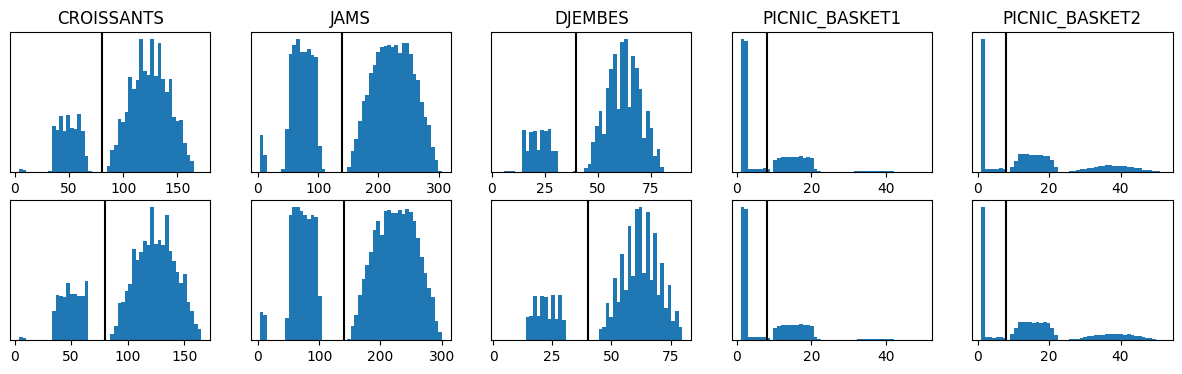

In [61]:
thrs = [80, 140, 40, 8, 8]

fig, ax = plt.subplots(2, 5, figsize=(15, 4))
for i, prod in enumerate([cro, jam, dje, bas1, bas2]):
    ax[0, i].hist(prod['bid_volume_1'], bins=50)
    ax[1, i].hist(prod['ask_volume_1'], bins=50)
    ax[0, i].axvline(thrs[i], c='k')
    ax[1, i].axvline(thrs[i], c='k')
    ax[0, i].set_title(prod.iloc[0]['product'])
    ax[0, i].set_yticks([])
    ax[1, i].set_yticks([])
plt.show()

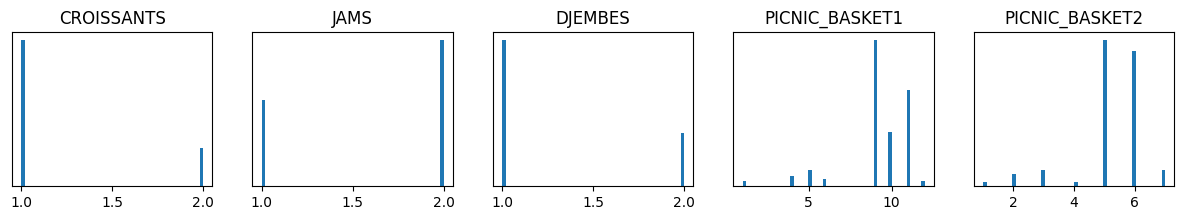

In [62]:
fig, ax = plt.subplots(1, 5, figsize=(15, 2))
for i, prod in enumerate([cro, jam, dje, bas1, bas2]):
    ax[i].hist(prod['ask_price_1'] - prod['bid_price_1'], bins=50)
    ax[i].set_title(prod.iloc[0]['product'])
    ax[i].set_yticks([])
plt.show()

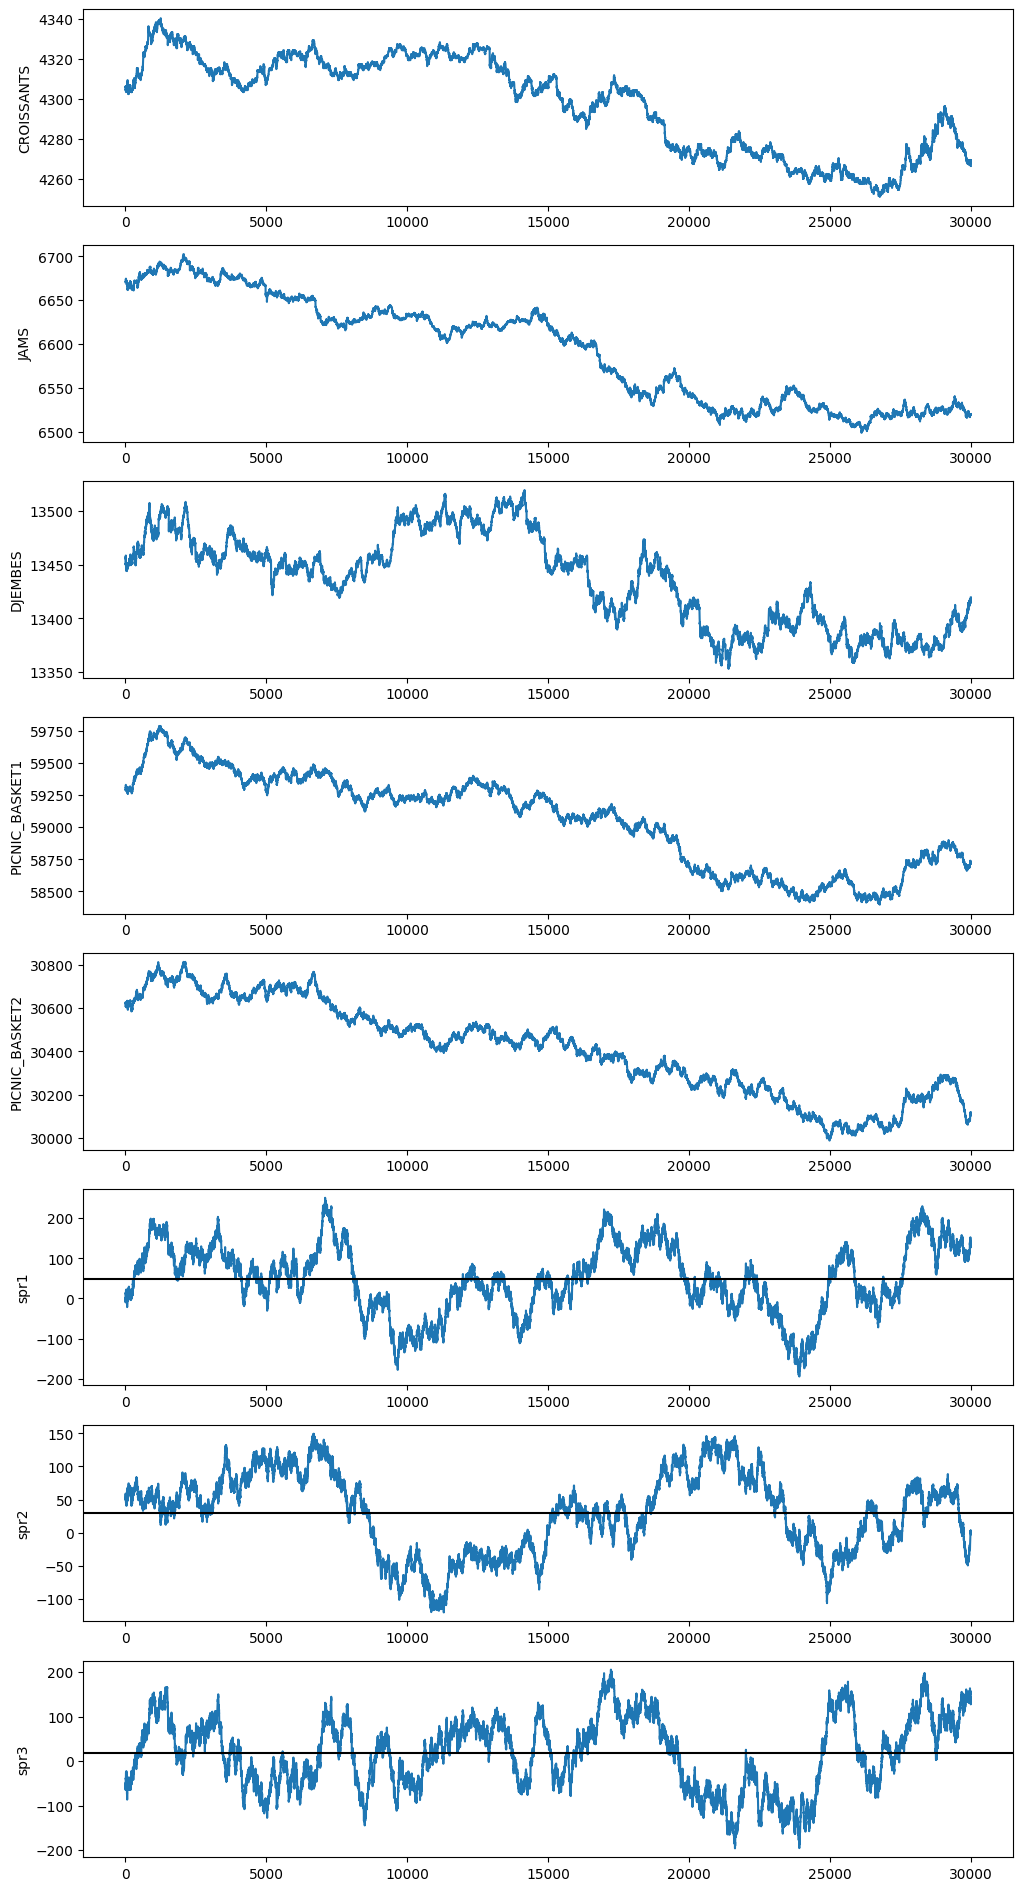

In [63]:
names = ['CROISSANTS', 'JAMS', 'DJEMBES', 'PICNIC_BASKET1', 'PICNIC_BASKET2', 'spr1', 'spr2', 'spr3']
fig, ax = plt.subplots(8, 1, figsize=(12, 24))
for i, prod in enumerate([cro['mid_price'], jam['mid_price'], dje['mid_price'], bas1['mid_price'], bas2['mid_price'], spr1, spr2, spr3]):
    ax[i].plot(prod)
    ax[i].set_ylabel(names[i])
ax[5].axhline(spr1.mean(), c='k')
ax[6].axhline(spr2.mean(), c='k')
ax[7].axhline(spr3.mean(), c='k')
plt.show()

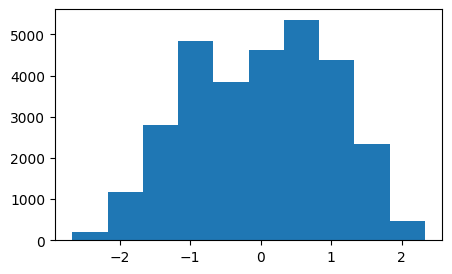

In [64]:
plt.figure(figsize=(5, 3))
plt.hist(spr3z, bins=10)
plt.show()

In [65]:
spr3.mean(), spr3.std()

(np.float64(18.526466666666668), np.float64(80.33068674852721))

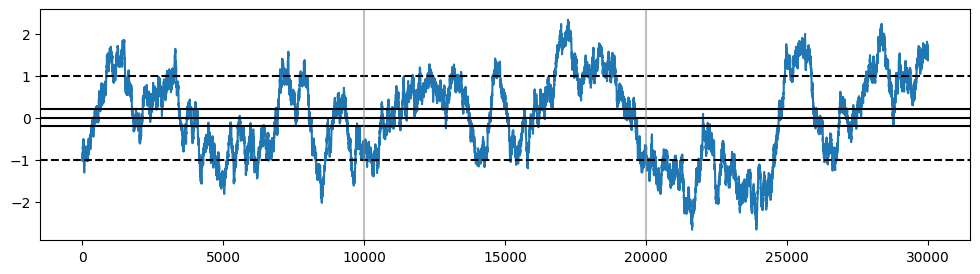

In [66]:
plt.figure(figsize=(12, 3))
plt.plot(spr3z)
plt.axhline(0, c='k')
plt.axhline(0.2, c='k')
plt.axhline(-0.2, c='k')
plt.axhline(1, c='k', linestyle='dashed')
plt.axhline(-1, c='k', linestyle='dashed')
plt.axvline(10000, c='gray', alpha=0.5)
plt.axvline(20000, c='gray', alpha=0.5)
plt.show()

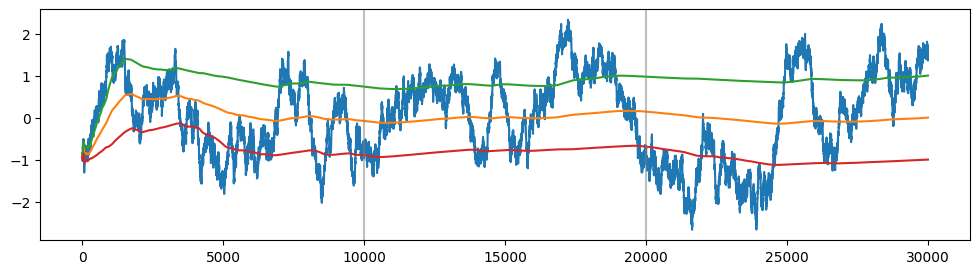

In [67]:
plt.figure(figsize=(12, 3))
plt.plot(spr3z)
plt.plot(spr3z.expanding().mean())
plt.plot(spr3z.expanding().mean() + spr3z.expanding().std())
plt.plot(spr3z.expanding().mean() - spr3z.expanding().std())
# plt.plot(spr3z.expanding().mean() + 4 * spr3z.rolling(100).std())
# plt.plot(spr3z.expanding().mean() - 4 * spr3z.rolling(100).std())
plt.axvline(10000, c='gray', alpha=0.5)
plt.axvline(20000, c='gray', alpha=0.5)
plt.show()

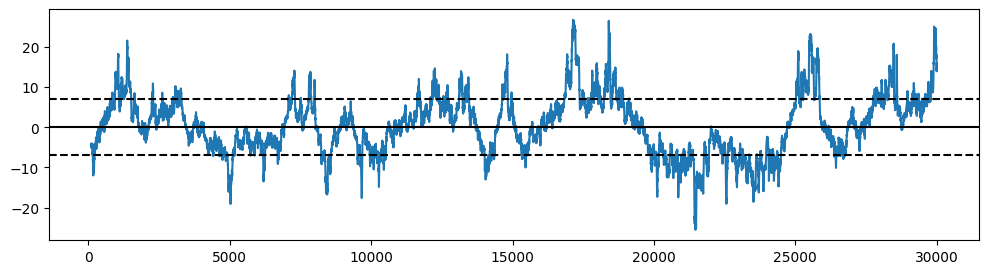

In [48]:
thr = 7
plt.figure(figsize=(12, 3))
plt.plot((spr3 - spr3.mean()) / spr3.rolling(100).std())
plt.axhline(0, c='k')
plt.axhline(thr, c='k', linestyle='dashed')
plt.axhline(-thr, c='k', linestyle='dashed')
# plt.ylim([-thr, thr])
# plt.axvline(10000, c='gray', alpha=0.5)
# plt.axvline(20000, c='gray', alpha=0.5)
plt.show()

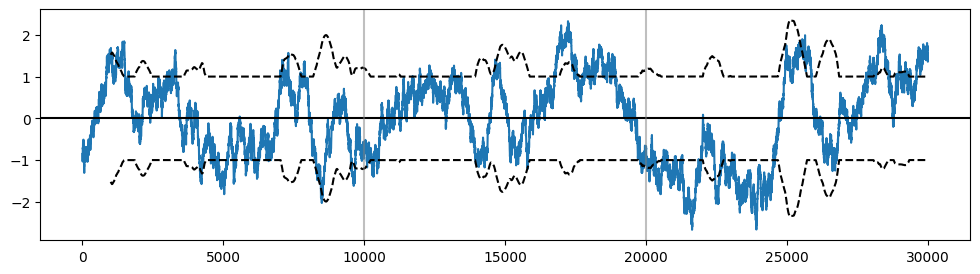

In [26]:
plt.figure(figsize=(12, 3))
plt.plot(spr3z)
plt.axhline(0, c='k')
plt.plot(np.maximum(2 * spr3z.rolling(1000).std(), np.ones(spr3z.shape[0])), c='k', linestyle='dashed')
plt.plot(-np.maximum(2 * spr3z.rolling(1000).std(), np.ones(spr3z.shape[0])), c='k', linestyle='dashed')
plt.axvline(10000, c='gray', alpha=0.5)
plt.axvline(20000, c='gray', alpha=0.5)
plt.show()

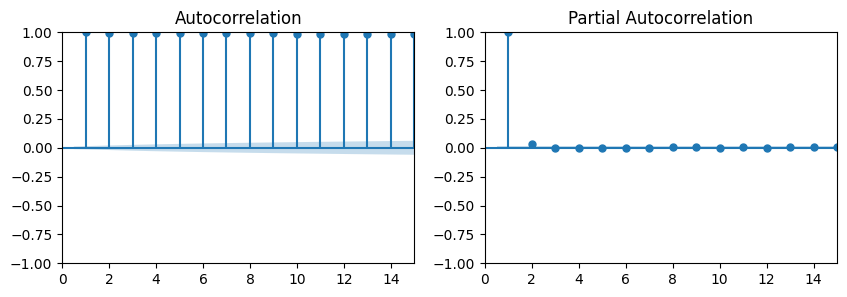

In [155]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(spr3, ax=ax[0], zero=False)
plot_pacf(spr3, ax=ax[1], zero=False)
ax[0].set_xlim([0, 15])
ax[1].set_xlim([0, 15])
plt.show()

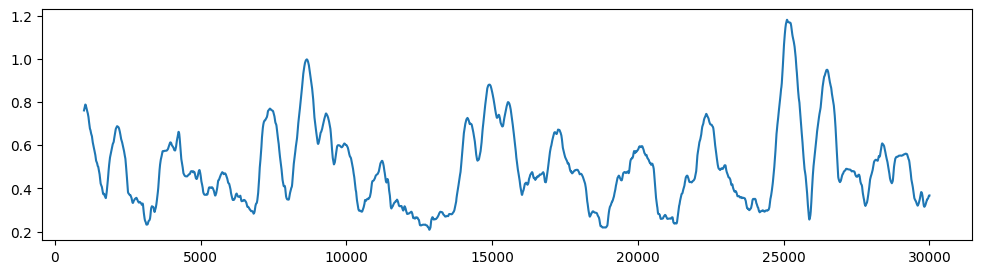

In [150]:
plt.figure(figsize=(12, 3))
plt.plot(spr3z.rolling(1000).std())
plt.show()

In [3]:
# cro = cro.assign(sw_mid=lambda x: (x['bid_price_1'] * x['ask_volume_1'] + x['ask_price_1'] * x['bid_volume_1']) / (x['bid_volume_1'] + x['ask_volume_1']))
# jam = jam.assign(sw_mid=lambda x: (x['bid_price_1'] * x['ask_volume_1'] + x['ask_price_1'] * x['bid_volume_1']) / (x['bid_volume_1'] + x['ask_volume_1']))
# dje = dje.assign(sw_mid=lambda x: (x['bid_price_1'] * x['ask_volume_1'] + x['ask_price_1'] * x['bid_volume_1']) / (x['bid_volume_1'] + x['ask_volume_1']))
# bas1 = bas1.assign(sw_mid=lambda x: (x['bid_price_1'] * x['ask_volume_1'] + x['ask_price_1'] * x['bid_volume_1']) / (x['bid_volume_1'] + x['ask_volume_1']))
# bas2 = bas2.assign(sw_mid=lambda x: (x['bid_price_1'] * x['ask_volume_1'] + x['ask_price_1'] * x['bid_volume_1']) / (x['bid_volume_1'] + x['ask_volume_1']))

In [57]:
spread = spr3z
x_lag = spread.shift(1).dropna()
x_ret = spread.diff().dropna()
model = OLS(x_ret, add_constant(x_lag)).fit()

In [58]:
model.params

const        0.000080
mid_price   -0.001097
dtype: float64

In [ ]:
def estimate_ou_parameters(spread_series: pd.Series):
    """
    Estimate OU process parameters from a spread time series.

    Returns:
        - theta: Speed of mean reversion
        - mu: Long-term mean
        - sigma: Volatility of residuals
        - half_life: Mean reversion half-life
    """

    spread = spread_series.dropna()
    x_lag = spread.shift(1).dropna()
    x_ret = spread.diff().dropna()

    # Align series
    x_lag = x_lag.loc[x_ret.index]

    # OLS regression: dx = theta * (mu - x)
    model = OLS(x_ret, add_constant(x_lag)).fit()
    beta = model.params[1]
    theta = -np.log(1 + beta)

    # Long-term mean
    mu = model.params[0] / (1 + beta)

    # Half-life of mean reversion
    half_life = np.log(2) / theta if theta > 0 else np.inf

    # Volatility of residuals
    sigma = np.std(model.resid)

    return {
        'theta': theta,
        'mu': mu,
        'sigma': sigma,
        'half_life': half_life,
        'model': model
    }

result = estimate_ou_parameters(spr3z)

print(f"Mean reversion half-life: {result['half_life']:.2f} time units")
print(f"Theta: {result['theta']:.4f}, Mu: {result['mu']:.4f}, Sigma: {result['sigma']:.4f}")

plt.figure(figsize=(12,4))
plt.plot(spr3z, label="Spread")
plt.axhline(result['mu'], color='red', linestyle='--', label="OU Mean")
plt.title("Spread with OU Estimated Mean")
plt.legend()
plt.grid(True)
plt.show()
